In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools as st
import sklearn.metrics as skm
import statsmodels.api as sm
import scipy.stats as stats
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
plt.rcParams["figure.figsize"] = (15, 3)

In [3]:
soy_data = [pd.read_csv(f'../data/futures_{year}.csv', index_col=0) for year in range(2020, 2023)]
full_data = pd.concat([soy_data[0][['SBL']], soy_data[1][['SBL']], soy_data[2][['SBL']]]).reset_index(drop=True)
weather_data = [pd.read_csv(f'../data/weather_{year}.csv', index_col=0) for year in range(2020, 2023)]
full_w = pd.concat([weather_data[0]['weather'], weather_data[1]['weather'], weather_data[2]['weather']])

# Soybean Analysis

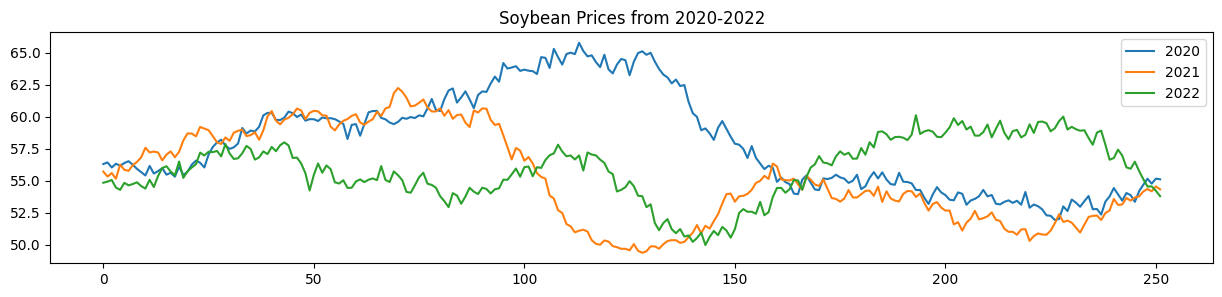

In [4]:
plt.title('Soybean Prices from 2020-2022')
for i, df in enumerate(soy_data):
    plt.plot(range(252), df['SBL'], label=f'202{i}')
plt.legend()

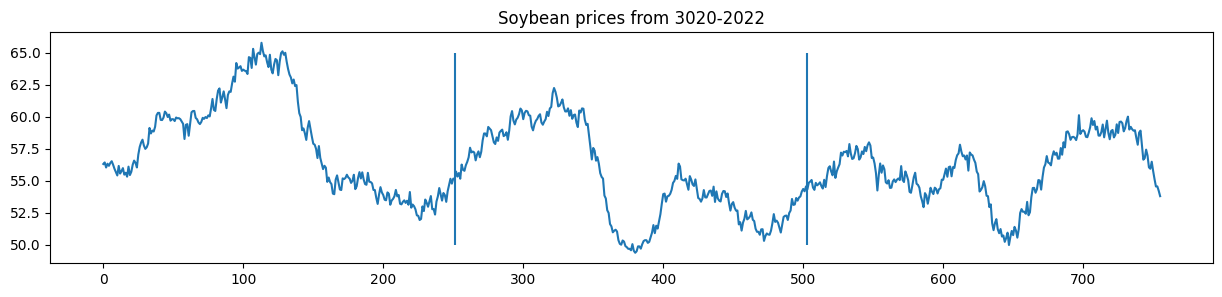

In [5]:
plt.vlines(x=[251, 503], ymin=50, ymax=65)

plt.title('Soybean prices from 3020-2022')
plt.plot(range(len(full_data)), full_data)
# plt.plot(full_w.to_numpy())

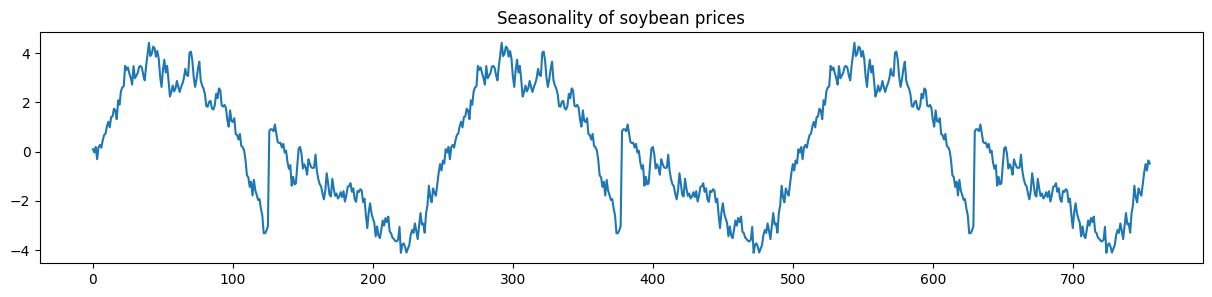

In [6]:
decomp = seasonal_decompose(full_data['SBL'].to_numpy(), model="additive", period=252)
plt.title('Seasonality of soybean prices')
# plt.plot(decomp.observed)
# plt.plot(decomp.trend)
# plt.plot(decomp.resid)
# plt.plot(decomp.trend + decomp.resid)
plt.plot(decomp.seasonal)

## Checking underlying distributions

(array([11., 15., 20., 20., 21., 20., 25., 40., 59., 49., 62., 36., 43.,
        36., 30., 24., 30., 45., 35., 43., 26.,  8.,  5.,  8.,  4.,  8.,
        11.,  9., 11.,  2.]),
 array([49.37918303, 49.92629916, 50.47341528, 51.02053141, 51.56764754,
        52.11476366, 52.66187979, 53.20899592, 53.75611204, 54.30322817,
        54.8503443 , 55.39746042, 55.94457655, 56.49169268, 57.0388088 ,
        57.58592493, 58.13304106, 58.68015718, 59.22727331, 59.77438944,
        60.32150556, 60.86862169, 61.41573782, 61.96285394, 62.50997007,
        63.0570862 , 63.60420232, 64.15131845, 64.69843458, 65.2455507 ,
        65.79266683]),
 <BarContainer object of 30 artists>)

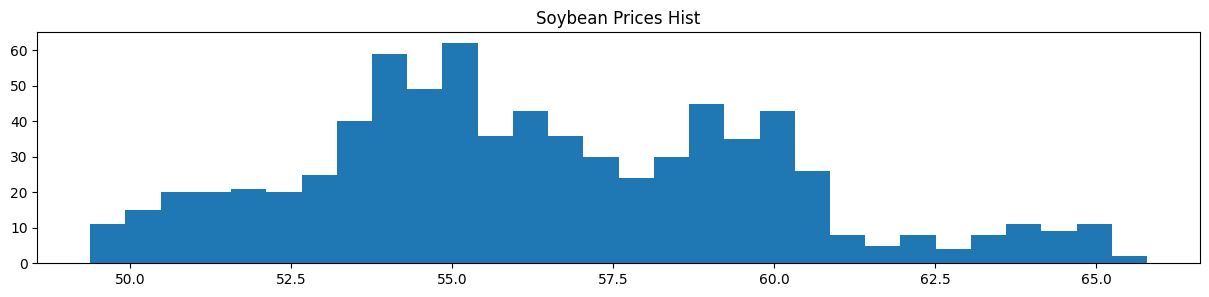

In [7]:
plt.title('Soybean Prices Hist')
plt.hist(full_data, bins=30)

In [8]:
soy_firsthalf = full_data[full_data.index % 252 < 126]
soy_secondhalf = full_data[full_data.index % 252 >= 126]

soy_spring = full_data[full_data.index % 252 < 63]
soy_summer = full_data[(full_data.index % 252 >= 63) & (full_data.index % 252 < 126)]
soy_fall = full_data[(full_data.index % 252 >= 126) & (full_data.index % 252 < 189)]
soy_winter = full_data[full_data.index % 252 >= 189]

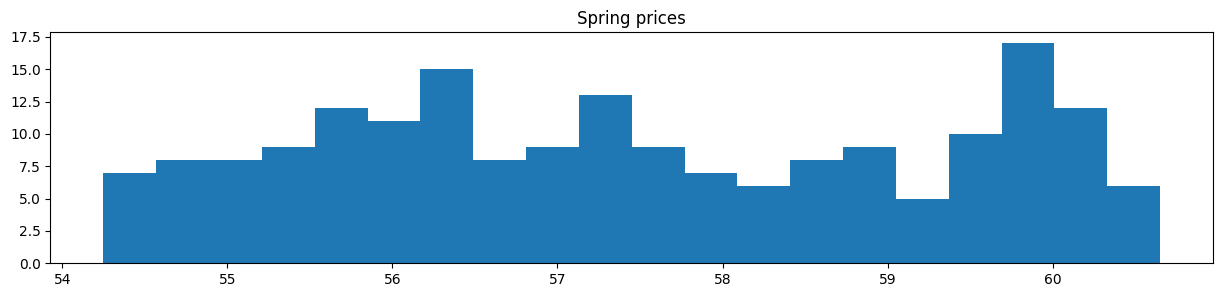

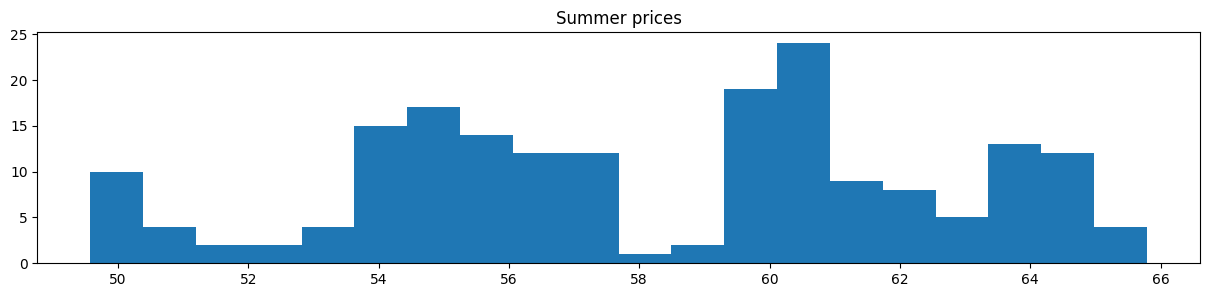

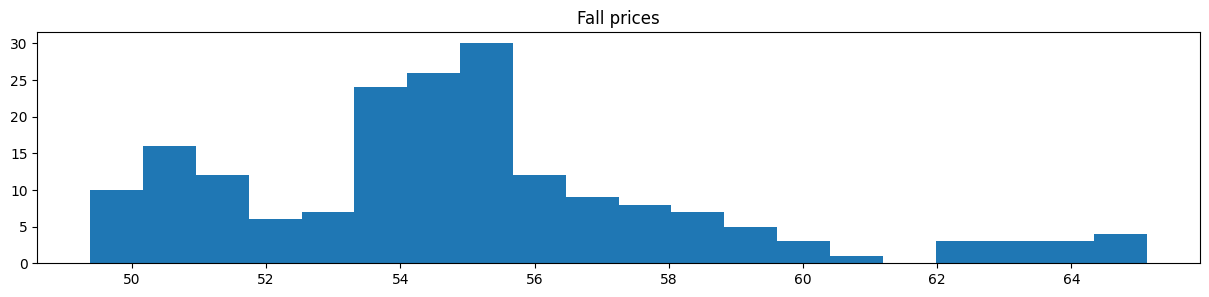

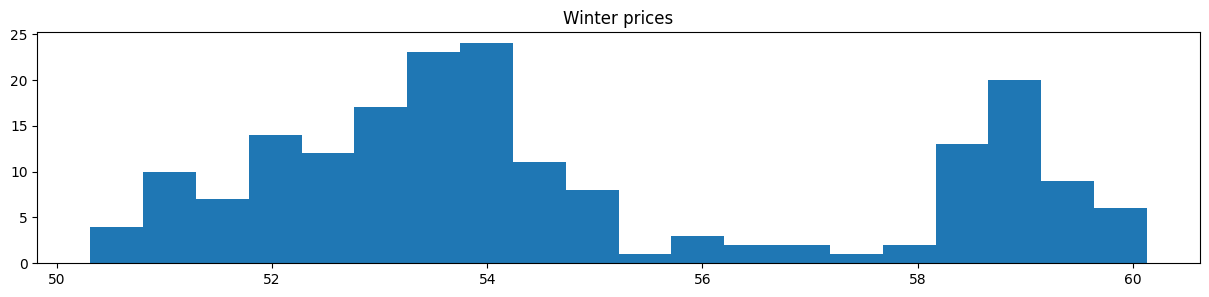

In [9]:
plt.title('Spring prices')
plt.hist(soy_spring, bins=20)
plt.show()
plt.title('Summer prices')
plt.hist(soy_summer, bins=20)
plt.show()
plt.title('Fall prices')
plt.hist(soy_fall, bins=20)
plt.show()
plt.title('Winter prices')
plt.hist(soy_winter, bins=20)
plt.show()

Next, we look at the returns.

mean: -1.4896175213522208e-05
variance: 9.116030333466132e-05


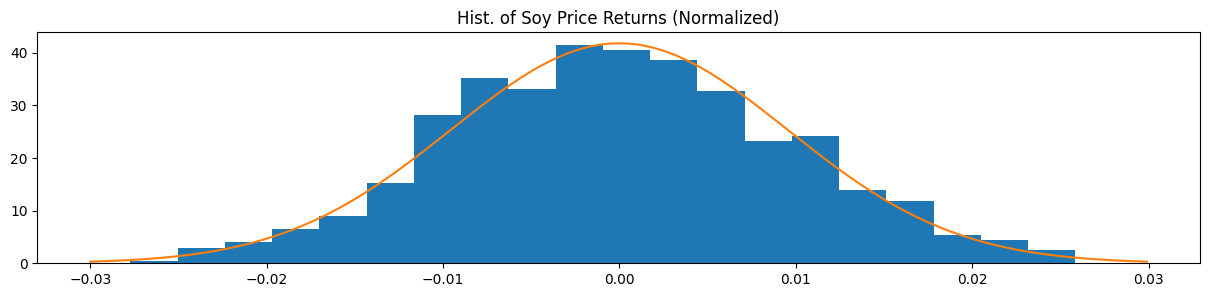

In [10]:
soy_ret = full_data['SBL'].pct_change().dropna().to_numpy()
plt.title('Hist. of Soy Price Returns (Normalized)')
plt.hist(soy_ret, bins=20, density=True)

mean = soy_ret.mean()
var = soy_ret.var()
x = np.arange(-0.03, 0.03, 0.0001)

plt.plot(x, 1 / (np.sqrt(2 * var * np.pi)) * np.exp(-(x - mean)**2 / (2 * var)))
print(f'mean: {mean}')
print(f'variance: {var}')

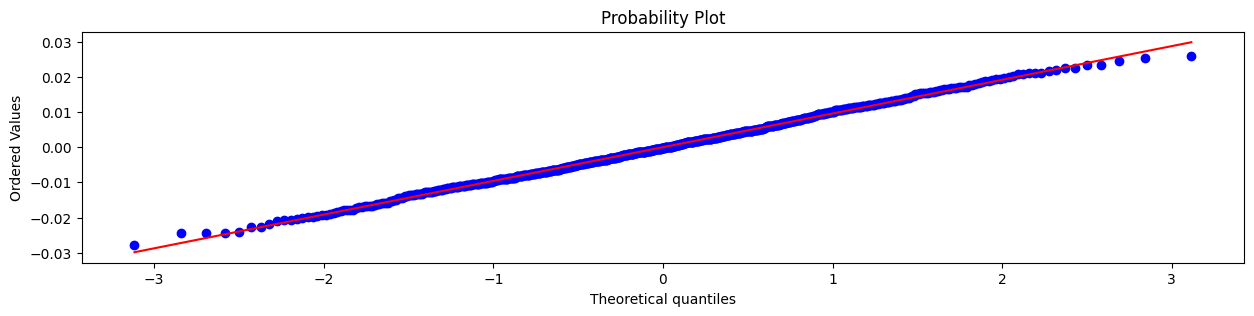

In [11]:
stats.probplot(soy_ret, dist='norm', plot=plt)
plt.show()

We find that the returns of SBL are normal.

mean: -6.046839389007168e-05
variance: 9.113656672214566e-05


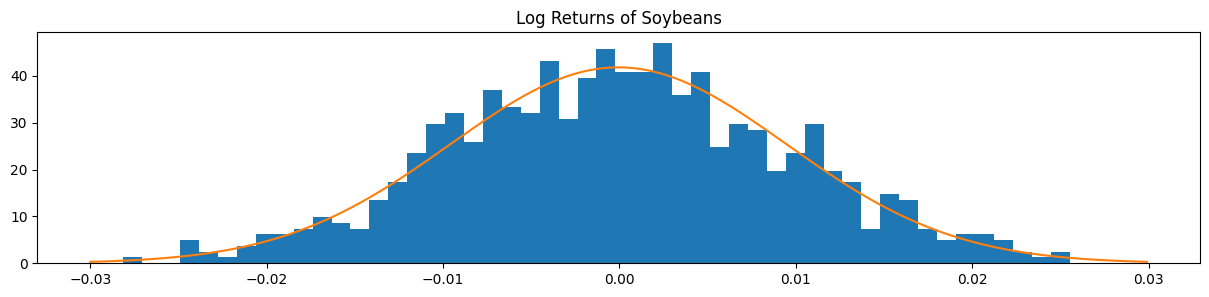

In [12]:
soy_log_ret = np.log1p(soy_ret)
plt.title('Log Returns of Soybeans')
plt.hist(soy_log_ret, bins=50, density=True)

mean = soy_log_ret.mean()
var = soy_log_ret.var()
x = np.arange(-0.03, 0.03, 0.0001)
plt.plot(x, 1 / (np.sqrt(2 * var * np.pi)) * np.exp(-(x - mean)**2 / (2 * var)))
print(f'mean: {mean}')
print(f'variance: {var}')

This suggests that we can use Geometric Brownian motion with our estimated parameters.

In [13]:
def gbm_expected_price(price_0=0, mean=0, var=1, periods=1):
    """
    Returns the expected price and +/- confidence interval for time series that follows GBM.
    """
    preds = [price_0 * np.exp((mean - var / 2) * 1 \
                + np.sqrt(var) * np.random.normal(0, np.sqrt(1))) for i in range(1, periods + 1)]
    confs = [1.96 * np.sqrt(var * i) for i in range(1, periods + 1)]
    return preds, confs

def test_gbm_model(data):
    preds = []
    confs = []

    for i in range(len(data)):
        pred, conf = gbm_expected_price(data[i], -6.046839389007168e-05, 9.113656672214566e-05)
        preds.append(pred[0])
        confs.append(conf[0])
    
    return preds, confs

0.7748367967878103

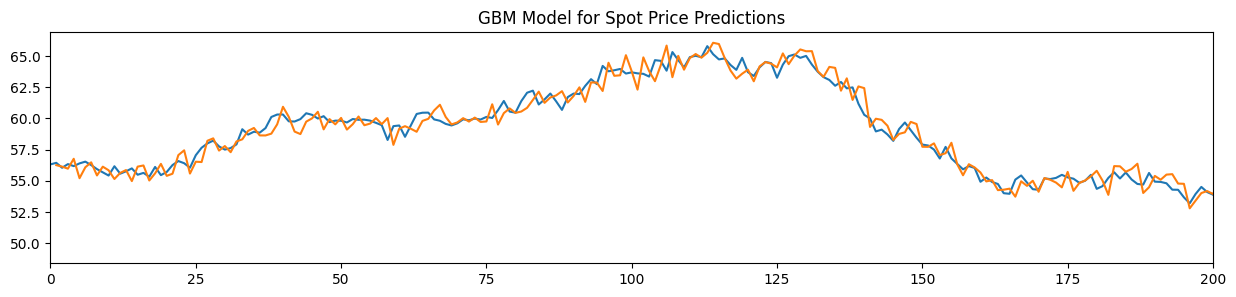

In [48]:
preds, conf = test_gbm_model(full_data['SBL'])
plt.title('GBM Model for Spot Price Predictions')
plt.plot(full_data['SBL'])
plt.plot(range(1, len(preds) + 1), preds)
# preds, _ = gbm_expected_price(full_data['SBL'][0], -6.046839389007168e-05, 9.113656672214566e-05, 10)
plt.xlim(left=0, right=200)
mse = skm.mean_squared_error(full_data['SBL'][1:], preds[:-1])
np.sqrt(mse)

# Futures + ETF Analysis

In [15]:
futures = pd.read_csv('../data/futures_2022.csv', index_col=0)
futures.head()

,LBSA,LBSB,LBSC,LBSD,LBSE,LBSF,LBSG,LBSH,LBSI,LBSJ,LBSK,LBSL,LBSM,LBSN,SBL
0,55.156256,55.458426,55.761101,56.064280,56.367966,56.672157,56.976856,57.282064,57.587780,57.894007,58.200744,58.507993,58.815754,59.124029,54.854589
1,55.229113,55.531405,55.834201,56.137502,56.441309,56.745623,57.050445,57.355775,57.661615,57.967964,58.274825,58.582197,58.890082,59.198481,54.941683
2,55.342782,55.645264,55.948250,56.251741,56.555739,56.860244,57.165257,57.470779,57.776810,58.083352,58.390405,58.697970,59.006048,59.314640,55.069542
3,54.733209,55.034674,55.336642,55.639113,55.942089,56.245570,56.549558,56.854052,57.159055,57.464566,57.770587,58.077119,58.384161,58.691716,54.475210
4,54.540254,54.841397,55.143042,55.445191,55.747843,56.051001,56.354664,56.658833,56.963510,57.268695,57.574389,57.880593,58.187308,58.494535,54.296839


<AxesSubplot: title={'center': 'Futures Prices'}>

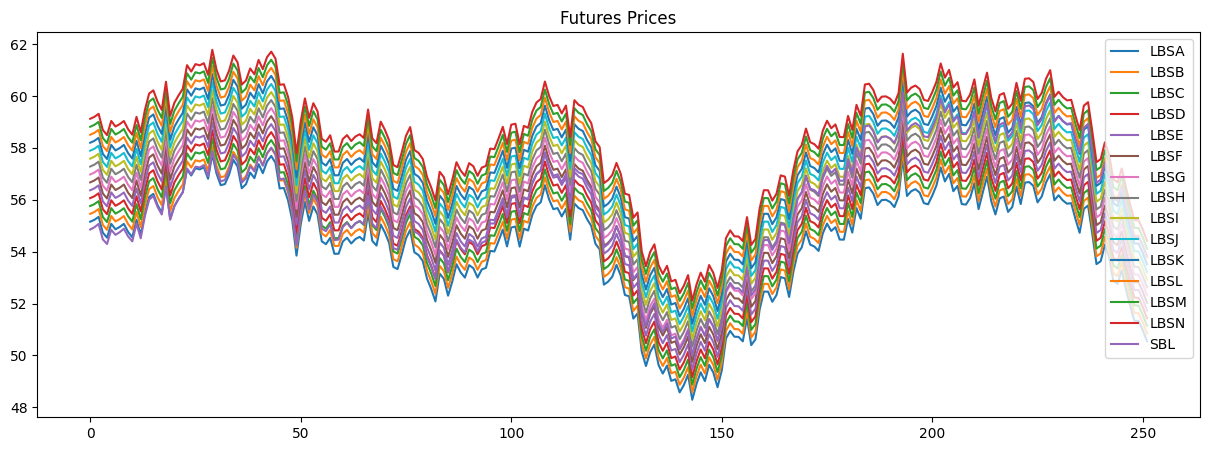

In [16]:
futures.plot(title='Futures Prices', figsize=(15,5))

In [17]:
futures.corr()

,LBSA,LBSB,LBSC,LBSD,LBSE,LBSF,LBSG,LBSH,LBSI,LBSJ,LBSK,LBSL,LBSM,LBSN,SBL
LBSA,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.892875
LBSB,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.892875
LBSC,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.892875
LBSD,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.892875
LBSE,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.892875
LBSF,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.892875
LBSG,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.892875
LBSH,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.892875
LBSI,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.892875
LBSJ,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.892875


Next, we must figure out the ETF price data. First, the futures expire at the end of each month. Each one only trades 1 share of the underlying asset. Second, ETFs are composed of 5 futures expiring next month, 3 in two months, and 2 in three months.

In [18]:
etf_prices = []

for i in range(len(futures)):
    price = 5 * futures[f'LBS{chr((ord("A") + int(i / 21)))}'][i] \
            + 3 * futures[f'LBS{chr((ord("A") + int(i / 21) + 1))}'][i] \
            + 2 * futures[f'LBS{chr((ord("A") + int(i / 21) + 2))}'][i]
    
    etf_prices.append(price)

futures['LLL'] = etf_prices

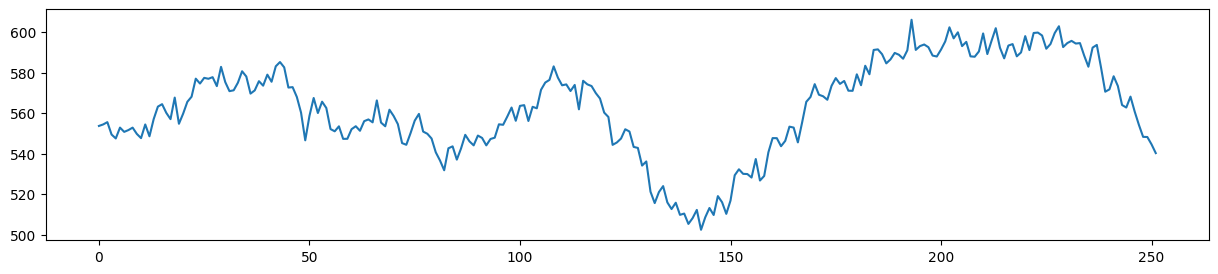

In [19]:
plt.plot(futures['LLL'])

# Weather Analysis

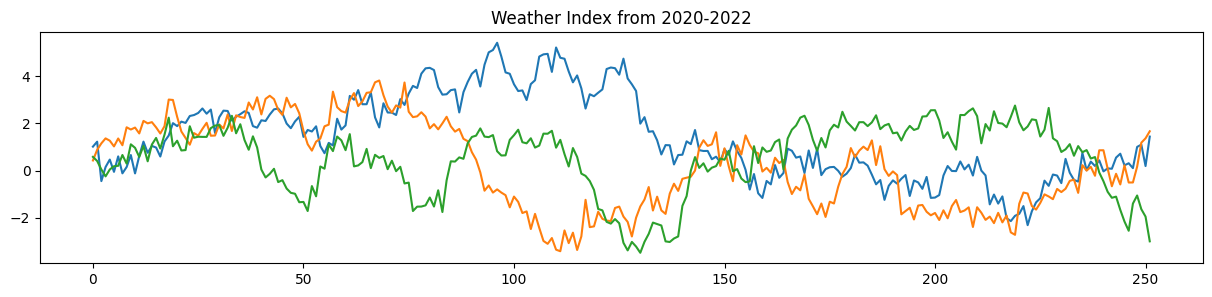

In [20]:
plt.title('Weather Index from 2020-2022')
for _, df in enumerate(weather_data):
    plt.plot(range(252), df['weather'])

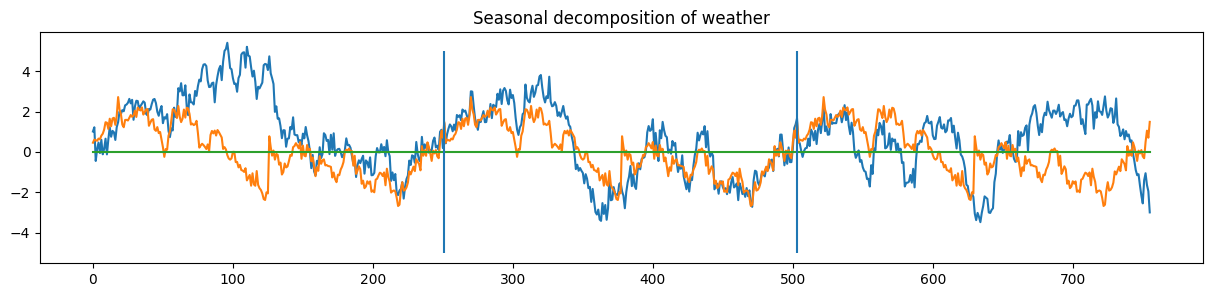

In [21]:
w_decomp = seasonal_decompose(full_w.to_numpy(), model='additive', period=252)
plt.plot(w_decomp.observed)
# plt.plot(w_decomp.resid)
# plt.plot(w_decomp.trend)
# plt.plot(w_decomp.trend + w_decomp.resid)
# plt.plot(w_decomp.observed - w_decomp.trend - w_decomp.resid)
plt.title('Seasonal decomposition of weather')
plt.plot(w_decomp.seasonal)
plt.plot([w_decomp.seasonal.mean()]*756)
plt.vlines(x=[251, 503], ymin=-5, ymax=5)
# plt.xlim(left=252, right=504)

### Autocorrelation between consecutive days

In [22]:
np.corrcoef(full_w[15:], full_w[:-15])

array([[1.        , 0.61984915],
       [0.61984915, 1.        ]])

In [23]:
print(f'mean: {np.mean(full_w)}')
print(f'var: {np.var(full_w)}')

mean: 0.7044317344182399
var: 3.0796804351250247


(array([ 5.,  1.,  9.,  5.,  4.,  4.,  7., 13., 12., 18., 16., 18., 12.,
        19., 16., 13., 17., 20., 27., 30., 38., 18., 27., 22., 36., 35.,
        29., 32., 22., 32., 33., 16., 32., 21., 14.,  8., 10.,  9., 14.,
         5.,  7.,  3.,  6.,  7.,  3.,  0.,  5.,  3.,  2.,  1.]),
 array([-3.48283847, -3.30493263, -3.12702678, -2.94912094, -2.7712151 ,
        -2.59330925, -2.41540341, -2.23749757, -2.05959172, -1.88168588,
        -1.70378004, -1.52587419, -1.34796835, -1.17006251, -0.99215666,
        -0.81425082, -0.63634498, -0.45843913, -0.28053329, -0.10262745,
         0.07527839,  0.25318424,  0.43109008,  0.60899592,  0.78690177,
         0.96480761,  1.14271345,  1.3206193 ,  1.49852514,  1.67643098,
         1.85433683,  2.03224267,  2.21014851,  2.38805436,  2.5659602 ,
         2.74386604,  2.92177189,  3.09967773,  3.27758357,  3.45548941,
         3.63339526,  3.8113011 ,  3.98920694,  4.16711279,  4.34501863,
         4.52292447,  4.70083032,  4.87873616,  5.056642  ,

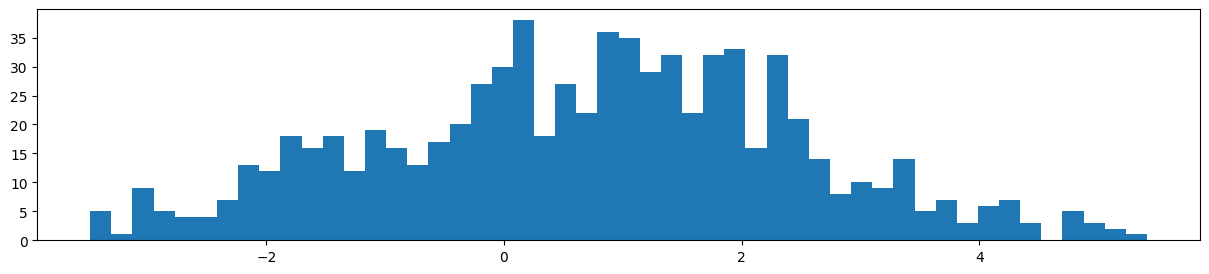

In [24]:
plt.hist(full_w, bins=50)

There doesn't seem to be a very clear trend for weather data aside from seasonality.

In [25]:
w_no_seas = full_w - w_decomp.seasonal
# mean = np.mean(w_no_seas)
mean = 0
var = np.var(w_no_seas)
print(f'mean: {mean}')
print(f'var: {var}')

mean: 0
var: 2.9065765665998224


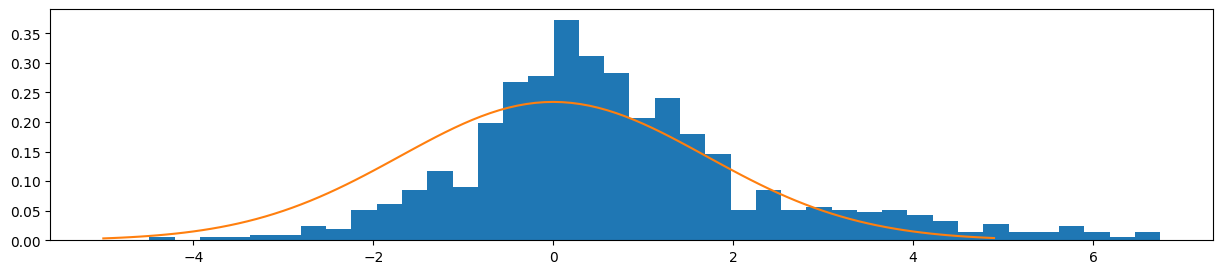

In [26]:
plt.hist(w_no_seas, bins=40, density=True)
x = np.arange(-5, 5, 0.1)
plt.plot(x, 1 / (np.sqrt(2 * var * np.pi)) * np.exp(-(x - mean)**2 / (2 * var)))
# y = 1 / (np.sqrt(2 * var * np.pi)) * np.exp(-(x - mean)**2 / (2 * var))
# plt.plot(x, y)

## Combining Weather with GBM Model

[0.8273928658695076,
 0.8490646085184801,
 0.8660726823774236,
 0.8819633686272389,
 0.8938345173210757,
 0.9028685720889777,
 0.9114565561827758,
 0.9161042572964535,
 0.9194070826557654,
 0.9180806552651403,
 0.917776546901705,
 0.9138785469586278]

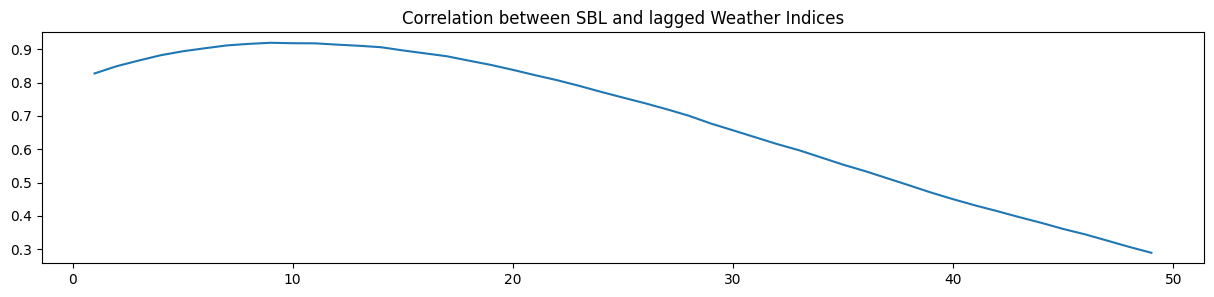

In [220]:
l = []

for i in range(1, 50):
    l.append(np.corrcoef(full_w[:-i], full_data['SBL'][i:])[1][0])

plt.title('Correlation between SBL and lagged Weather Indices')
plt.plot(range(1, len(l) + 1), l)
max(l)
l[0:12]
# l.index(max(l))

In [208]:
def gbm_corr_expected_price(exog, corrs, n_lags=10, price_0=0, mean=0, var=1):
    """
    Returns the expected price and +/- confidence interval for time series that follows GBM.
    """
    corr = np.mean(corrs[min(len(exog) - 1, n_lags)])
    ind = np.mean(exog[min(len(exog) - 1, n_lags)])
    pred = price_0 * np.exp((mean - var / 2) \
                + np.sqrt(var) * (corr * ind \
                + np.sqrt(1 - corr ** 2) * np.random.normal(0, 1)))
    return pred

def test_gbm_corr_model(data, exog, corrs, n_lags):
    preds = []

    for i in range(1, len(data) - 1):
        pred = gbm_corr_expected_price(exog[:i+1], corrs, n_lags, data[i], -6.046839389007168e-05, 9.113656672214566e-05)
        preds.append(pred)
    
    return preds

In [203]:
wth = full_w.reset_index(drop=True)
wth

0      1.013368
1      1.223060
2     -0.447239
3      0.148754
4      0.465278
         ...   
751   -1.398723
752   -1.056387
753   -1.637809
754   -1.950158
755   -2.997880
Name: weather, Length: 756, dtype: float64

0.22633827339915977

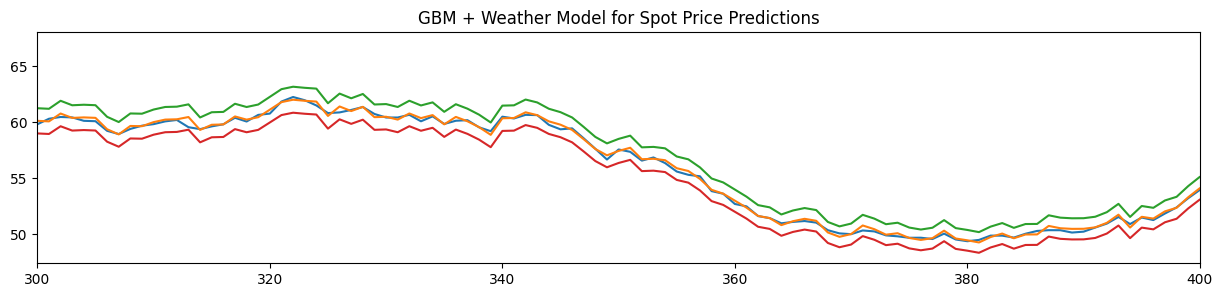

In [218]:
combined_preds = np.array(test_gbm_corr_model(full_data['SBL'], wth.to_numpy(), l, 8))
conf95 = 1.96 * np.sqrt(9.113656672214566e-05)
plt.title('GBM + Weather Model for Spot Price Predictions')
plt.plot(full_data['SBL'])
plt.plot(range(1, len(combined_preds) + 1), combined_preds)
plt.plot(range(1, len(combined_preds) + 1), combined_preds * (1 + conf95))
plt.plot(range(1, len(combined_preds) + 1), combined_preds * (1 - conf95))
# preds, _ = gbm_expected_price(full_data['SBL'][0], -6.046839389007168e-05, 9.113656672214566e-05, 10)
plt.xlim(left=300, right=400)
mse = skm.mean_squared_error(full_data['SBL'][1:-1], combined_preds)
# mse
np.sqrt(mse)
# skm.mean_absolute_error(full_data['SBL'][1:-1], combined_preds)

In [217]:
conf95 * 60

1.1226739709244447